# Enhanced Chunking and Vectorization with Docling


---

## Installation and Setup


In [ ]:
import sys
assert sys.version_info >= (3, 10) and sys.version_info < (3, 13), "Use Python 3.10, 3.11, or 3.12 to run this notebook."

In [ ]:
! pip install "git+https://github.com/ibm-granite-community/utils.git" \
    transformers \
    pillow \
    langchain_community \
    langchain_huggingface \
    langchain_milvus \
    docling \
    matplotlib \
    replicate

  Cloning https://github.com/ibm-granite-community/utils.git to /tmp/pip-req-build-k4s529t_
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite-community/utils.git /tmp/pip-req-build-k4s529t_
  Resolved https://github.com/ibm-granite-community/utils.git to commit c9a6b769ec5f436629cecf649afcd8f130908c30
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━

Now let's import the essential modules:

In [ ]:
import os
import sys
from pathlib import Path
import tempfile
import requests
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from typing import List, Dict, Any, Iterator, Optional

### Logging

To see detailed information about the document processing and chunking operations, we'll configure INFO log level.

NOTE: It is okay to skip running this cell if you prefer less verbose output.

In [ ]:
import logging

logging.basicConfig(level=logging.INFO)

## Document Processing with Docling

### Understanding Document Structure

In [ ]:
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions

# Configure pipeline to extract both text and images
pdf_pipeline_options = PdfPipelineOptions(
    do_ocr=False,   # Skip OCR for faster processing (enable for scanned docs)
    generate_picture_images=True,   # Extract images for multi-modal applications
)
format_options = {
    InputFormat.PDF: PdfFormatOption(pipeline_options=pdf_pipeline_options),
}
converter = DocumentConverter(format_options=format_options)

# Process a sample document
sample_doc_url = "https://midwestfoodbank.org/images/AR_2020_WEB2.pdf"
result = converter.convert(sample_doc_url)
doc = result.document

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/docling/pipeline/standard_pdf_pipeline.py:262: RuntimeWarning: Mean of empty slice
  np.nanmean(
/usr/local/lib/python3.11/dist-packages/docling/pipeline/standard_pdf_pipeline.py:267: RuntimeWarning: Mean of empty slice
  np.nanmean(


---

## Chunk Visualization: See What You're Building


### Building a Comprehensive Chunk Analyzer

In [ ]:
from docling_core.transforms.chunker.tokenizer.base import BaseTokenizer
from docling.chunking import BaseChunker, BaseChunk
from docling.datamodel.document import DoclingDocument

def visualize_chunks(chunks: list[BaseChunk], *, chunker: BaseChunker, tokenizer: BaseTokenizer, title="Document Chunks"):
    """Visualize chunk sizes and distribution in tokens.
    """
    # Extract token counts for each chunk
    token_counts = [tokenizer.count_tokens(chunker.contextualize(chunk=chunk)) for chunk in chunks]

    # Create histogram with all annotations in one go
    plt.figure(figsize=(10, 6))

    # Create the histogram
    plt.hist(token_counts, bins=20, alpha=0.7, color='skyblue')

    # Add statistics line and annotations
    avg_tokens = np.mean(token_counts)
    plt.axvline(avg_tokens, color='red', linestyle='--', label=f'Average: {avg_tokens:.1f}')

    # Add labels and formatting
    plt.title(title)
    plt.xlabel('Chunk Size (tokens)')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.legend()

    # Show the complete plot
    plt.show()

    # Print comprehensive statistics
    print(f"Chunk Analysis Results:")
    print(f"Total chunks: {len(token_counts)}")
    print(f"Average chunk size: {np.mean(token_counts):.1f} tokens")
    print(f"Minimum chunk size: {min(token_counts)} tokens")
    print(f"Maximum chunk size: {max(token_counts)} tokens")
    print(f"Standard deviation: {np.std(token_counts):.1f} tokens")

    # Quality indicators
    if max(token_counts) > 512:
        print("Warning: Some chunks exceed 512 tokens - consider reducing chunk size")
    if np.std(token_counts) > 100:
        print("Warning: High variance in chunk sizes - retrieval consistency may suffer")

    # Also show character length for reference
    char_lengths = [len(chunk.text) for chunk in chunks]
    print(f"\nReference - Average character length: {np.mean(char_lengths):.1f} characters")

## Docling Chunking Fundamentals: Understanding the Architecture


### The BaseChunker Interface

In [ ]:
# Example of BaseChunker interface structure
class SimpleChunker(BaseChunker):
    """A simple example chunker implementing the BaseChunker interface."""

    def chunk(self, dl_doc: DoclingDocument, **kwargs) -> Iterator[BaseChunk]:
        """Return chunks for the provided document."""
        # Simple implementation: one chunk per page
        for i, page in enumerate(dl_doc.pages):
            text = " ".join([item.text for item in page.items if hasattr(item, "text")])
            metadata = {
                "page": i,
                "source": dl_doc.name
            }
            yield BaseChunk(text=text, metadata=metadata)

    def serialize(self, chunk: BaseChunk) -> str:
        """Serialize a chunk for embedding."""
        # Simple serialization: just return the text
        return chunk.text

---

## Chunking Strategies Deep Dive



### Strategy 1: HierarchicalChunker - Respecting Document Structure

In [ ]:
# Import the tokenizer for HybridChunker
from transformers import AutoTokenizer
from docling_core.transforms.chunker.tokenizer.huggingface import HuggingFaceTokenizer
from docling_core.transforms.chunker.hierarchical_chunker import HierarchicalChunker

# Set up the tokenizer - using IBM Granite for this example
embeddings_model_path = "ibm-granite/granite-embedding-30m-english"
embeddings_tokenizer = HuggingFaceTokenizer(
    tokenizer=AutoTokenizer.from_pretrained(embeddings_model_path),
)

Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors


Generated 168 chunks with HierarchicalChunker


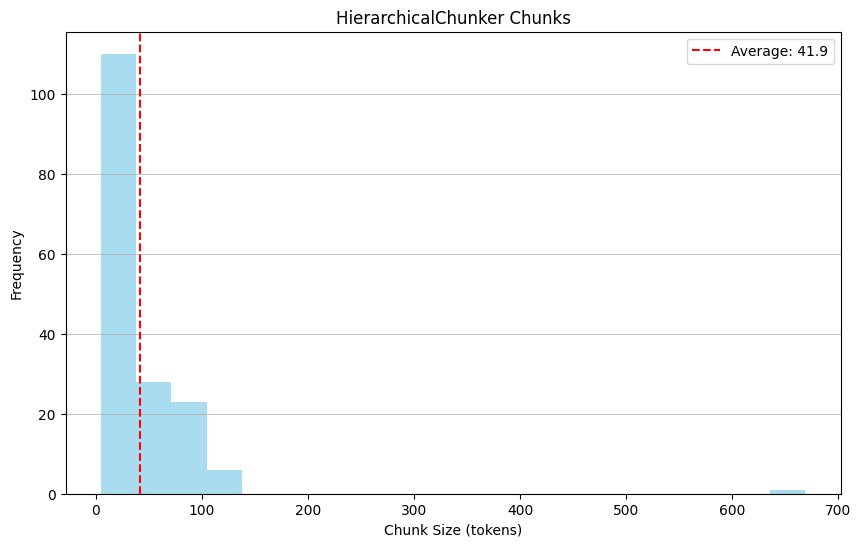

Chunk Analysis Results:
Total chunks: 168
Average chunk size: 41.9 tokens
Minimum chunk size: 5 tokens
Maximum chunk size: 669 tokens
Standard deviation: 56.5 tokens

Reference - Average character length: 130.4 characters

Sample Chunk Analysis:
Text (first 200 chars): All  MFB  locations  remained  open  and  responsive  to  the  need  of  our nonprofit partners. We enacted safety protocols and reduced volunteer numbers  to  maintain  social  distancing  guidelines...
Chunk type: DocChunk
Document metadata available in 'meta'
Meta preview: schema_name='docling_core.transforms.chunker.DocMeta' version='1.0.0' doc_items=[TextItem(self_ref='#/texts/5', parent=RefItem(cref='#/body'), children=[], content_layer=<ContentLayer.BODY: 'body'>, l...


In [ ]:
# Create a HierarchicalChunker
hierarchical_chunker = HierarchicalChunker()

# Generate chunks
hierarchical_chunks = list(hierarchical_chunker.chunk(doc))

# Visualize the chunks
print(f"Generated {len(hierarchical_chunks)} chunks with HierarchicalChunker")
visualize_chunks(
    chunks=hierarchical_chunks,
    title="HierarchicalChunker Chunks",
    chunker=hierarchical_chunker,
    tokenizer=embeddings_tokenizer,
)

# Examine chunk structure
sample_chunk = hierarchical_chunks[2]
print(f"\nSample Chunk Analysis:")
print(f"Text (first 200 chars): {sample_chunk.text[:200]}...")
print(f"Chunk type: {type(sample_chunk).__name__}")

# Print available metadata
if hasattr(sample_chunk, 'dl_meta'):
    print("Document metadata available in 'dl_meta'")
elif hasattr(sample_chunk, 'meta'):
    print(f"Document metadata available in 'meta'")
    print(f"Meta preview: {str(sample_chunk.meta)[:200]}...")

### Strategy 2: HybridChunker - Balancing Structure and Size

HybridChunker Results:
Generated 74 chunks


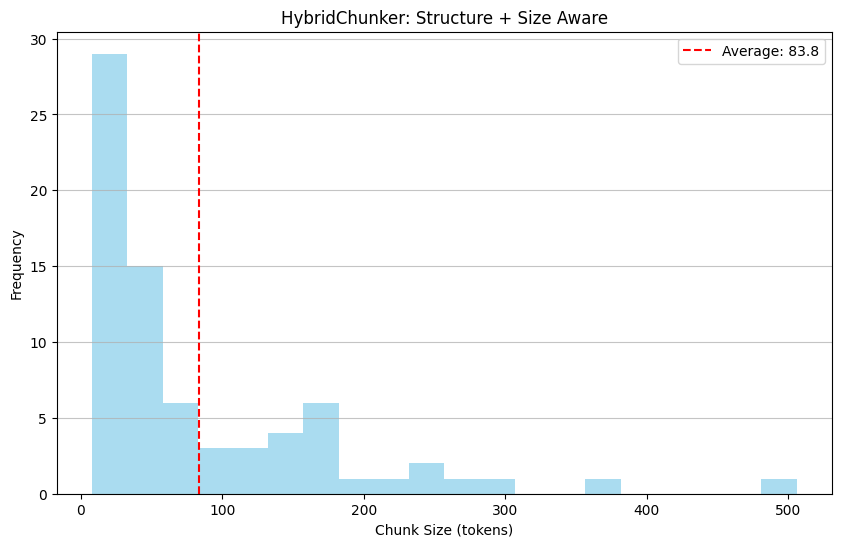

Chunk Analysis Results:
Total chunks: 74
Average chunk size: 83.8 tokens
Minimum chunk size: 8 tokens
Maximum chunk size: 506 tokens
Standard deviation: 91.4 tokens

Reference - Average character length: 296.9 characters

Strategy Comparison:
HierarchicalChunker: 168 chunks
HybridChunker: 74 chunks
Reduction: 56.0%

Sample HybridChunker Chunk:
Text (first 200 chars): bridging the gap between poverty and prosperity...
Metadata available - includes structural information


In [ ]:

# Import HybridChunker
from docling_core.transforms.chunker.hybrid_chunker import HybridChunker

# Create a HybridChunker with default settings
hybrid_chunker = HybridChunker(
    tokenizer=embeddings_tokenizer,
)

# Generate chunks
hybrid_chunks = list(hybrid_chunker.chunk(doc))

# Analyze the results
print(f"HybridChunker Results:")
print(f"Generated {len(hybrid_chunks)} chunks")

visualize_chunks(
    chunks=hybrid_chunks,
    title="HybridChunker: Structure + Size Aware",
    chunker=hybrid_chunker,
    tokenizer=embeddings_tokenizer,
)

# Compare with HierarchicalChunker
print(f"\nStrategy Comparison:")
print(f"HierarchicalChunker: {len(hierarchical_chunks)} chunks")
print(f"HybridChunker: {len(hybrid_chunks)} chunks")
print(f"Reduction: {((len(hierarchical_chunks) - len(hybrid_chunks)) / len(hierarchical_chunks) * 100):.1f}%")

# Examine a sample chunk with context
sample_hybrid_chunk = hybrid_chunks[0]
print(f"\nSample HybridChunker Chunk:")
print(f"Text (first 200 chars): {sample_hybrid_chunk.text[:200]}...")

if hasattr(sample_hybrid_chunk, 'meta'):
    print(f"Metadata available - includes structural information")

## Advanced Configuration and Fine-Tuning



### Understanding the Impact of Chunk Size


Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors


Advanced HybridChunker Results (64 token limit):
Generated 102 chunks


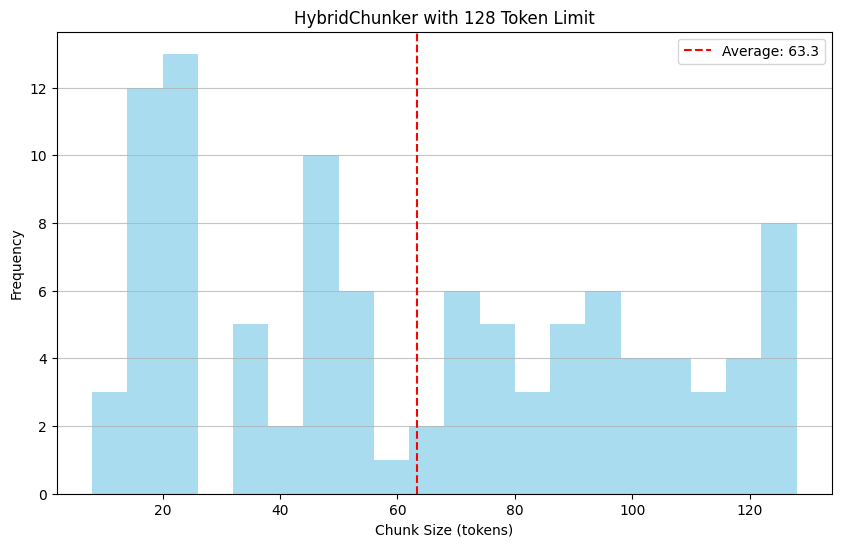

Chunk Analysis Results:
Total chunks: 102
Average chunk size: 63.3 tokens
Minimum chunk size: 8 tokens
Maximum chunk size: 128 tokens
Standard deviation: 37.0 tokens

Reference - Average character length: 215.1 characters


In [ ]:
# Create a more constrained tokenizer for demonstration

max_tokens=128  # Smaller chunks for fine-grained retrieval

adv_tokenizer = HuggingFaceTokenizer(
    tokenizer=AutoTokenizer.from_pretrained(embeddings_model_path),
    max_tokens=max_tokens,
)

adv_chunker = HybridChunker(
    tokenizer=adv_tokenizer,
)

adv_chunks = list(adv_chunker.chunk(doc))

print(f"Advanced HybridChunker Results (64 token limit):")
print(f"Generated {len(adv_chunks)} chunks")

visualize_chunks(
    chunks=adv_chunks,
    title=f"HybridChunker with {max_tokens} Token Limit",
    chunker=adv_chunker,
    tokenizer=adv_tokenizer,
)

### The Power of Contextualization


In [ ]:
# Demonstrate contextualization - how chunks get additional context
print(f"\n Understanding Contextualization:")
print(f"Contextualization adds relevant surrounding information to improve retrieval quality.\n")

for i, chunk in enumerate(adv_chunks[:5]):
    tokens_text = adv_tokenizer.count_tokens(chunk.text)
    contextualized = adv_chunker.contextualize(chunk)
    tokens_contextualized = adv_tokenizer.count_tokens(contextualized)

    print(f"Chunk {i}:")
    print(f"Original text ({tokens_text} tokens): {chunk.text[:100]}...")
    print(f"Contextualized ({tokens_contextualized} tokens): {contextualized[:100]}...")
    print(f"Context added: {tokens_contextualized - tokens_text} tokens\n")


 Understanding Contextualization:
Contextualization adds relevant surrounding information to improve retrieval quality.

Chunk 0:
Original text (8 tokens): bridging the gap between poverty and prosperity...
Contextualized (8 tokens): bridging the gap between poverty and prosperity...
Context added: 0 tokens

Chunk 1:
Original text (54 tokens): No one could have predicted the events of 2020. The global COVID-19 pandemic created a dynamic year....
Contextualized (72 tokens): A message from Co-Founder, President, and CEO, David Kieser
No one could have predicted the events o...
Context added: 18 tokens

Chunk 2:
Original text (104 tokens): All  MFB  locations  remained  open  and  responsive  to  the  need  of  our nonprofit partners. We ...
Contextualized (122 tokens): A message from Co-Founder, President, and CEO, David Kieser
All  MFB  locations  remained  open  and...
Context added: 18 tokens

Chunk 3:
Original text (103 tokens): • MFB distributed a record amount of food, 37% more th

---

## Next Steps and Advanced Topics

Congratulations! You now understand the fundamentals of document chunking with Docling.

### Resources for Further Learning:
- [Docling Documentation](https://docling-project.github.io/docling/)
- [RAG Best Practices Guide](https://python.langchain.com/docs/tutorials/rag/)
- [Chunking Strategies Research](https://arxiv.org/search/?query=text+chunking+retrieval)
